In [28]:
import string
import os
import numpy as np
from matplotlib import pyplot as plt

In [29]:
with open('eminem.txt', 'r') as iofile:
    text = iofile.readlines()
    

link for eminem.txt : https://drive.google.com/file/d/19v1V3I8MHy8Y_K0DsNbdnEeYzj8uBq39/view?usp=sharing

In [30]:
import string

text = ''.join(text).lower()



assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In [31]:
junk = '0123456789[]{}…/å"*'


for i in range(len(junk)):
    text = text.replace(junk[i], '')

text = text.replace('\n\n', '\n')
text = text.replace('...', '.')
text = text.replace('women singing:', '')
text = text.replace('chorus:', '')
text = text.replace('eminem:', '')
text = text.replace('thyme:', '')
text = text.replace('verse:', '')



text = text.replace('–', ' ')
text = text.replace('—', ' ')
names = text.split('\n')

for line in names:
    if (len(line)<19):
        names.remove(line)


In [32]:
tokens = sorted(set(text))
indexes = np.arange(0, len(tokens))

In [33]:
id_to_token = dict(zip(indexes, tokens))

token_to_id = dict(zip(tokens, indexes))

### Building the model

In [40]:
from IPython.display import clear_output
from random import sample
from torch.autograd import Variable
from torch import nn
from torch import optim
from IPython import display
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

max_line_length = max(map(len, names))
tokens_amount = len(tokens)

In [41]:
def encrypt_batch(batch, max_len, pad=token_to_id[' '], dtype='int32', batch_first = True):
    
    max_len = max_len or max(map(len, batch))
    result = np.zeros([len(batch), max_len], dtype) + pad

    for i in range(len(batch)):
        encrypted_line = [token_to_id[c] for c in batch[i]]
        result[i, :len(encrypted_line)] = encrypted_line
        
    if not batch_first: 
        result = np.transpose(result)

    return result

In [42]:
class VanillaRNN(nn.Module):
    def __init__(self, tokens_amount=tokens_amount, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(tokens_amount, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, tokens_amount)
        
    def forward(self, x, hidden=None):
        h_seq, hidden = self.rnn(self.emb(x), hidden)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden
    


In [43]:
model = VanillaRNN().to(device)
optimzer = torch.optim.Adam(model.parameters())

In [44]:
#Plot the loss function (axis X: number of epochs, axis Y: loss function).
def train_NN_and_plot_loss(model, optimizer, n_epochs, samples_taken_amount):
    loss_history = []
    for k in range(n_epochs):
        for i in range(samples_taken_amount):
            batch_encrypted = encrypt_batch(sample(names, 32), max_line_length)
            batch_encrypted = torch.tensor(batch_encrypted, dtype=torch.int64).cuda()
          
            logp_seq = model(batch_encrypted)[0]
          
            # compute loss
            predictions_logp = logp_seq[:, :-1]
            actual_next_tokens = batch_encrypted[:, 1:]

            loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
          
            # train with backprop
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
            loss_history.append(loss.data.cpu().numpy())
    
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.grid()
        plt.plot(loss_history, 'b', label="train loss")
        plt.legend()
        plt.show()
    return loss_history

In [ ]:
n_epochs = 50
samples_taken_amount = 200
losses = train_NN_and_plot_loss(model, optimzer, n_epochs, samples_taken_amount)

In [0]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=max_line_length, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).cuda()
    hid_state = None
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        _, hid_state = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        logp_next, hid_state = char_rnn(x_sequence[:, -1].view(1, -1), hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.cpu().numpy()[0]
        
        # sample next token and push it back into x_sequence
     
        next_ix = np.random.choice(tokens_amount, p=p_next.squeeze(0))
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).cuda()
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0]])

In [0]:
def generate_text(model,  temp = 1.0, length = 20):
    for _ in range(length):
      print(generate_sample(model, temperature = temp))

In [411]:
generate_text(model, 1.1, 40)

                                                                                                                                                                                                                                                                                                                                                        
                                                                                                                                                                                                                                                                                                                                                        
 go a my fich or i show my i metters priatable                                                                                                                                                                                                                                                                        

### Let's use LSTM instead of vanilla RNN and compare the results.

In [0]:
class LSTM(nn.Module):
    def __init__(self, tokens_amount=tokens_amount, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(tokens_amount, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, tokens_amount)
        
    def forward(self, x, hidden=None):
        h_seq, hidden = self.rnn(self.emb(x), hidden)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden
    


In [0]:
model_lstm = LSTM().to(device)
optimize_lstm = torch.optim.Adam(model_lstm.parameters())

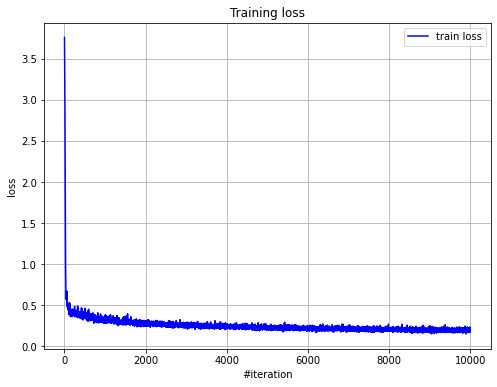

In [414]:
lstm_losses = train_NN_and_plot_loss(model_lstm, optimize_lstm, n_epochs, samples_taken_amount)

In [415]:
for t in [0.1, 0.2, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2.0]:
  print(f'=================temp = {t}======================')
  generate_text(model_lstm, t, 25)
  print('================================================')

=================temp = 0.1======================
                                                                                                                                                                                                                                                                                                                                                        
                                                                                                                                                                                                                                                                                                                                                        
                                                                                                                                                                                                                                                                    

Unfortunately my NN isn't so cool for Eminem's rap. In rap there are a lot of short lines, plenty of short words like 'ya', 'haha' etc. Al these things cause generation of nonsense even with low temperature. Because of huge amount of spaces and short words there are a lot of empty lines in geberated text even with normal temperature. 
Perhaps the reason of such poor machine-rap is small and not-cleaned training sample (I just went to the site with Marshall songs' lyrics and copied the text of 30 or 40 song from 5 different albums.) Anyway, I've tried :)

### Saving and loading models

In [417]:
torch.save(model_lstm.state_dict(), 'my_rap_generator')

my_model = LSTM()
my_model.load_state_dict(torch.load('my_rap_generator'))
my_model.to(device)

generate_text(my_model, 1.0, 60)

 lookt me                                                                                                                                                                                                                                                                                                                                               
 you fagce it, they right. about the moon bod a whough eody, super                                                                                                                                                                                                                                                                                      
 bum whitgile fuck up on a roec                                                                                                                                                                                                                                                                                       

hmm, here i got something not bad that could be a rap for someone like 6ix9ine